#  Displacement-based Earthquake Loss Assessment - Silva et al. 2013

In this fragility method, thousands of synthetic buildings can be produced considering probabilistic distributions for the variability in the geometrical and material properties. The nonlinear capacity can be estimated using the displacement-based earthquake loss assessment theory. In this process, the performance against a large set of ground motion records is been calculated. Global limit states are used to estimate the distribution of buildings in each damage state for different levels of ground motion, and a regression algorithm is applied to derive fragility functions for each limit state.

In the following figure, a fragility model developed using this method is presented: 
<img src="../../../../../figures/fragility_example.png" width="400" align="middle">

##Load capacity curves

In order to use this methodology, it is necessary to provide one (or a group) of capacity curves, defined according to the format established on the [RMTK manual](../../../../../rmtk-docs.pdf). Please provide the location of the folder containing this input using the parameter input_folder.

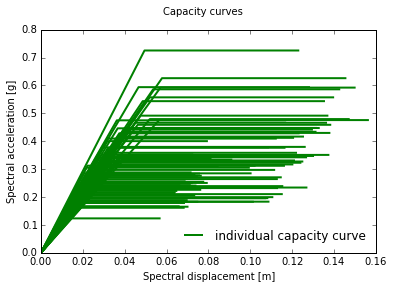

In [1]:
from rmtk.vulnerability.common import utils
%matplotlib inline 

capacity_curves_file = '../../../../../../rmtk_data/capacity_curves_dbela.csv'
capacity_curves = utils.read_capacity_curves(capacity_curves_file)
utils.plot_capacity_curves(capacity_curves)

## Load ground motion records

In [2]:
gmrs_folder = '../../../../../../rmtk_data/accelerograms'
gmrs = utils.read_gmrs(gmrs_folder)
minT = 0.1
maxT = 2
#utils.plot_response_spectra(gmrs,minT,maxT)

##Calculate fragility function


1%
2%
3%
4%
5%
6%
7%
8%
9%
10%
11%
12%
13%
14%
15%
16%
17%
18%
19%
20%
21%
22%
23%
24%
25%
26%
27%
28%
29%
30%
31%
32%
33%
34%
35%
36%
37%
38%
39%
40%
41%
42%
43%
44%
45%
46%
47%
48%
49%
50%
51%
52%
53%
54%
55%
56%
57%
58%
59%
60%
61%
62%
63%
64%
65%
66%
67%
68%
69%
70%
71%
72%
73%
74%
75%
76%
77%
78%
79%
80%
81%
82%
83%
84%
85%
86%
87%
88%
89%
90%
91%
92%
93%
94%
95%
96%
97%
98%
99%
100%


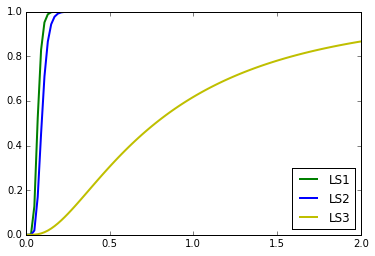

In [4]:
import DBELA

damage_model = utils.read_damage_model('../../../../../../rmtk_data/damage_model_dbela_low_code.csv')
structure_type = 'bare frame'
PDM = DBELA.calculate_fragility(capacity_curves,gmrs,damage_model,structure_type)
damping = 0.05
T = 2.0
regression_method = 'least squares'
fragility_model = utils.calculate_mean_fragility(gmrs,PDM,T,damping,'Sa',damage_model,regression_method)
utils.plot_fragility_model(fragility_model,0.01,2)